# 1. Загрузка данных

Проанализируем данные такси в Нью-Йорке за май 2016 года

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d

Загрузим данные с сайта и взглянем на них

In [142]:
regions_df = pd.read_csv('regions.csv', sep=';')

In [143]:
regions_df.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [144]:
data = pd.read_csv('yellow_tripdata_2016-06.csv')

In [145]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-06-09 21:06:36,2016-06-09 21:13:08,2,0.79,-73.983360,40.760937,1,N,-73.977463,40.753979,2,6.0,0.5,0.5,0.00,0.0,0.3,7.30
1,2,2016-06-09 21:06:36,2016-06-09 21:35:11,1,5.22,-73.981720,40.736668,1,N,-73.981636,40.670242,1,22.0,0.5,0.5,4.00,0.0,0.3,27.30
2,2,2016-06-09 21:06:36,2016-06-09 21:13:10,1,1.26,-73.994316,40.751072,1,N,-74.004234,40.742168,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-06-09 21:06:36,2016-06-09 21:36:10,1,7.39,-73.982361,40.773891,1,N,-73.929466,40.851540,1,26.0,0.5,0.5,1.00,0.0,0.3,28.30
4,2,2016-06-09 21:06:36,2016-06-09 21:23:23,1,3.10,-73.987106,40.733173,1,N,-73.985909,40.766445,1,13.5,0.5,0.5,2.96,0.0,0.3,17.76


# 2. Фильтрация данных

Для начала создадим новый признак - длительность поездки

In [146]:
data['duration'] = pd.to_datetime(data['tpep_dropoff_datetime']) - pd.to_datetime(data['tpep_pickup_datetime'])

Удаляем поездки с нулевой длительностью

In [147]:
data.drop(data[data['duration'].dt.seconds <= 0].index, inplace=True)

Удаляем поездки с нулевым количеством пассажиров

In [148]:
data.drop(data[data['passenger_count'] <= 0].index, inplace=True)

Удаляем поездки с нулевым расстоянием по счетчику

In [149]:
data.drop(data[data['trip_distance'] <= 0].index, inplace=True)

Удаляем поездки с координатами начала не попадающими в прямоугольник Нью-Йорка

In [150]:
# границы прямоугольника Нью-Йорка
min_latitude = 40.49612
max_latitude = 40.91553
min_longitude = -74.25559
max_longitude = -73.70001

In [151]:
data.drop(data[(data['pickup_longitude'] > max_longitude) | (data['pickup_longitude'] < min_longitude)].index, inplace=True)

In [152]:
data.drop(data[(data['pickup_latitude'] > max_latitude) | (data['pickup_latitude'] < min_latitude)].index, inplace=True)

# 3. Агрегация данных по областям

Создаем регионы по уникальным значениям координат в файле regions

In [153]:
binx = np.sort(pd.concat([regions_df['south'],regions_df['north']]).unique())
biny = np.sort(pd.concat([regions_df['west'],regions_df['east']]).unique())

Создаем признак "День и час в который началась поездка" (pickup_datehour)

In [154]:
data['pickup_datehour'] = pd.to_datetime(data['tpep_pickup_datetime']).dt.floor('h')

Вытаскиваем аггрегированные по областям данные

Используем expand_binnumbers=True в binned_statistic_2d для получения двойного индекса области (по широте и долготе) для каждой из поездок тк в ином случае индексы областей пронумерованы не по порядку

In [155]:
agg_data = binned_statistic_2d(x=data['pickup_latitude'], y=data['pickup_longitude'], values=None, statistic='count', bins=[binx,biny], expand_binnumbers=True)

Сводим индексы областей к сквозной нумерации согласно regions.csv и создаем соответствующий признак region_number в датафрейме

In [156]:
data['region_number'] = 50 * (agg_data.binnumber[1,:] - 1) + agg_data.binnumber[0,:]

Теперь агрегируем данные для каждой из областей по часам начала поездки и выведем первые строки этой таблицы

In [157]:
region_time_data = data.groupby(['pickup_datehour', 'region_number']).size().reset_index(name='trips')

Добавляем в датафрейм пары час-ячейка, которым не соответствует ни одна поездка

In [158]:
idx = pd.MultiIndex.from_product([region_time_data['pickup_datehour'].unique(),
                                  np.arange(1, 2501)],
                                 names=['pickup_datehour', 'region_number'])

In [159]:
region_time_data = region_time_data.set_index(['pickup_datehour', 'region_number']).reindex(idx, fill_value=0).reset_index()

По какой-то причине pandas выводит на печать дату, но не время в колонке pickup_datehour при выводе всего или только начала датафрейма region_time_data. Тем не менее время в этой колонке записано, и обнуление минут и секунд также учтены

In [160]:
region_time_data.head()

,pickup_datehour,region_number,trips
0,2016-06-01,1,0
1,2016-06-01,2,0
2,2016-06-01,3,0
3,2016-06-01,4,0
4,2016-06-01,5,0


In [161]:
for i in range(5):
    print region_time_data['pickup_datehour'][i]

2016-06-01 00:00:00
2016-06-01 00:00:00
2016-06-01 00:00:00
2016-06-01 00:00:00
2016-06-01 00:00:00


# 4. Использование агрегированных данных

## а. Поездки из ячейки содержащей Empire State Building

Запишем взятые из Google Maps координаты Empire State Building

In [162]:
esb_latitude = 40.748503
esb_longitude =  -73.985520

Найдем соответствующую данным координатам ячейку

In [163]:
esb_region = regions_df[(regions_df['north'] >= esb_latitude) & (regions_df['south'] <= esb_latitude) & \
                        (regions_df['west'] <= esb_longitude) & (regions_df['east'] >= esb_longitude)]['region'].values[0]

In [164]:
esb_time_data = region_time_data[region_time_data['region_number'] == esb_region][['pickup_datehour', 'trips']]

При выводе этого датафрейма на печать колонка pickup_datehour выводится как нужно

In [165]:
esb_time_data.head()

,pickup_datehour,trips
1230,2016-06-01 00:00:00,435
3730,2016-06-01 01:00:00,211
6230,2016-06-01 02:00:00,124
8730,2016-06-01 03:00:00,95
11230,2016-06-01 04:00:00,83


Построим график зависимости количества поездок из региона Empire State Building в зависимости от даты и часа начала поездки

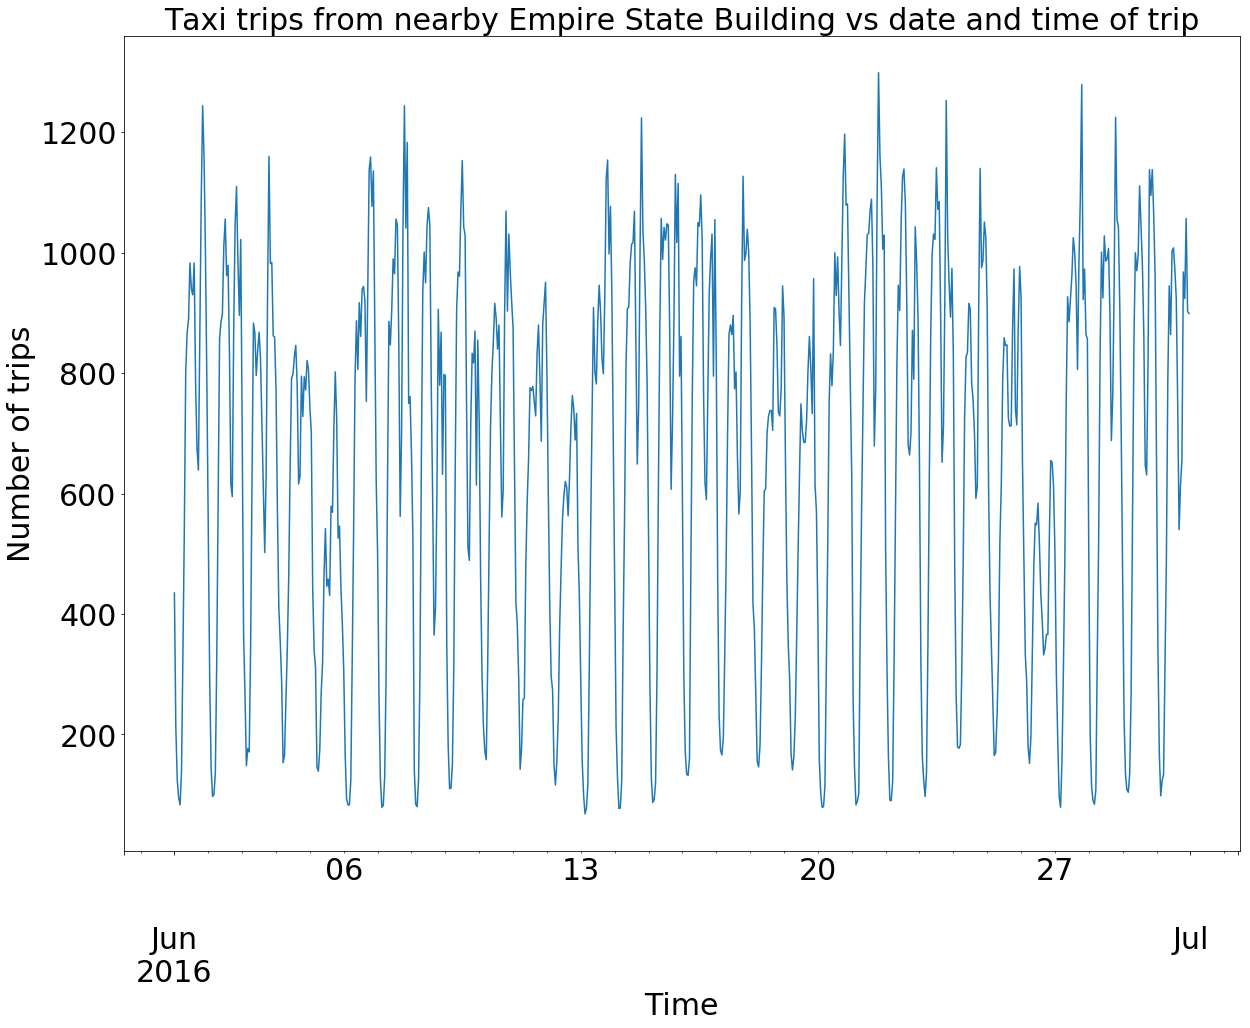

In [166]:
esb_time_data.plot('pickup_datehour', 'trips', figsize=(20, 15), legend=None, fontsize=30);
plt.xlabel("Time", fontsize=30);
plt.ylabel("Number of trips", fontsize=30);
plt.title("Taxi trips from nearby Empire State Building vs date and time of trip", fontsize=30);

## b. Пары "час-ячейка" без поездок

In [167]:
print("Количество пар \"час-ячейка\" в мае 2016 года без поездок равно " + str(len(region_time_data[region_time_data['trips'] == 0])))

Количество пар "час-ячейка" в мае 2016 года без поездок равно 1665094


In [168]:
region_time_data.to_csv('Yellow_taxi_aggregated_data_06.csv', sep='\t')